<a href="https://colab.research.google.com/github/unachankz/goto_data_science/blob/master/notebook/racoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tochvisionを用いた実験

[参考URL](https://towardsdatascience.com/building-your-own-object-detector-pytorch-vs-tensorflow-and-how-to-even-get-started-1d314691d4ae)



PyTorch has a package called torchvision that includes model architectures, data sets, and other helpful functions for computer vision. Torchvision also has a subpackage on object detection which we will be using in this section. A lot of the following setup and code is modeled according to torchvision’s object detection tutorial.



In [1]:
import pycocotools


In [2]:
# Clone the PyTorch vision repo and copy some python files

%%bash
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [3]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [4]:
def parse_one_annot(path_to_data_file, filename):
   data = pd.read_csv(path_to_data_file)
   boxes_array = data[data["filename"] == filename][["xmin", "ymin",        
   "xmax", "ymax"]].values
   
   return boxes_array

In [5]:
class RaccoonDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
      self.root = root
      self.transforms = transforms
      self.imgs = sorted(os.listdir(os.path.join(root, "images")))
      self.path_to_data_file = data_file

    def __getitem__(self, idx):
      # load images and bounding boxes
      img_path = os.path.join(self.root, "images", self.imgs[idx])
      img = Image.open(img_path).convert("RGB")
      box_list = parse_one_annot(self.path_to_data_file, 
      self.imgs[idx])
      boxes = torch.as_tensor(box_list, dtype=torch.float32)
      num_objs = len(box_list)
      # there is only one class
      labels = torch.ones((num_objs,), dtype=torch.int64)
      image_id = torch.tensor([idx])
      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
      # suppose all instances are not crowd
      iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
      target = {}
      target["boxes"] = boxes
      target["labels"] = labels
      target["image_id"] = image_id
      target["area"] = area
      target["iscrowd"] = iscrowd
      if self.transforms is not None:
        img, target = self.transforms(img, target)
      return img, target
    def __len__(self):
      return len(self.imgs)

In [6]:
!git clone https://github.com/experiencor/raccoon_dataset

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
Receiving objects: 100% (646/646), 48.00 MiB | 9.39 MiB/s, done.
Resolving deltas: 100% (412/412), done.


In [7]:
import os
dataset = RaccoonDataset(root= "./raccoon_dataset",
data_file= "./raccoon_dataset/data/raccoon_labels.csv")
dataset.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=650x417 at 0x7FE73E778690>,
 {'area': tensor([141120.]),
  'boxes': tensor([[ 81.,  88., 522., 408.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1])})

In [8]:
def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [9]:
def get_transform(train):
  transforms = []
  # converts the image, a PIL image, into a PyTorch Tensor
  transforms.append(T.ToTensor())
  if train:
    # during training, randomly flip the training images
    # and ground-truth for data augmentation
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [10]:
# use our dataset and defined transformations
dataset = RaccoonDataset(root= "./raccoon_dataset",data_file= "./raccoon_dataset/data/raccoon_labels.csv",transforms = get_transform(train=True))
dataset_test = RaccoonDataset(root= "./raccoon_dataset",  data_file= "./raccoon_dataset/data/raccoon_labels.csv",  transforms = get_transform(train=False))
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader( dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader( dataset_test, batch_size=1, shuffle=False, num_workers=4,         collate_fn=utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 200 examples, 160 are training and 40 testing


In [11]:
torch.cuda.is_available()


True

In [13]:
import torchvision
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - raccoon and not racoon
num_classes = 2
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,   step_size=3,             gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [14]:
# let's train it for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch,
                    print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/80]  eta: 0:01:13  lr: 0.000068  loss: 1.4653 (1.4653)  loss_classifier: 1.3221 (1.3221)  loss_box_reg: 0.1101 (0.1101)  loss_objectness: 0.0126 (0.0126)  loss_rpn_box_reg: 0.0205 (0.0205)  time: 0.9128  data: 0.2521  max mem: 2418
Epoch: [0]  [10/80]  eta: 0:00:27  lr: 0.000701  loss: 0.7950 (0.8568)  loss_classifier: 0.6623 (0.6988)  loss_box_reg: 0.1494 (0.1439)  loss_objectness: 0.0047 (0.0059)  loss_rpn_box_reg: 0.0062 (0.0082)  time: 0.3994  data: 0.0285  max mem: 2820
Epoch: [0]  [20/80]  eta: 0:00:22  lr: 0.001333  loss: 0.2906 (0.5699)  loss_classifier: 0.1388 (0.4272)  loss_box_reg: 0.1242 (0.1285)  loss_objectness: 0.0037 (0.0056)  loss_rpn_box_reg: 0.0062 (0.0086)  time: 0.3478  data: 0.0059  max mem: 3185
Epoch: [0]  [30/80]  eta: 0:00:19  lr: 0.001965  loss: 0.2370 (0.4592)  loss_classifier: 0.1124 (0.3190)  loss_box_reg: 0.1116 (0.1232)  loss_objectness: 0.0052 (0.0058)  loss_rpn_box_reg: 0.0081 (0.0111)  time: 0.3696  data: 0.0059  max mem: 3564
Epoch: [

In [16]:
os.mkdir("./raccoon/")
torch.save(model.state_dict(), "./raccoon/model")

In [20]:
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("./raccoon/model"))

<All keys matched successfully>

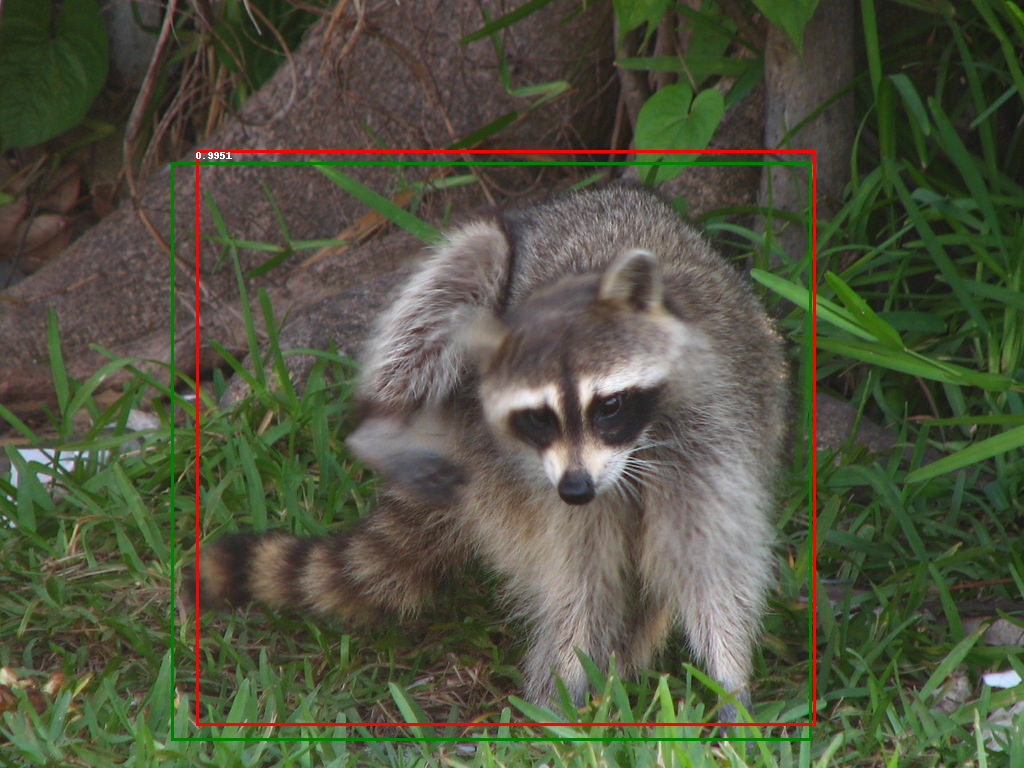

In [23]:
from PIL import ImageDraw
idx = 0
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
  prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# draw groundtruth
for elem in range(len(label_boxes)):
  draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
  (label_boxes[elem][2], label_boxes[elem][3])], outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
  boxes = prediction[0]["boxes"][element].cpu().numpy()
  score = np.round(prediction[0]["scores"][element].cpu().numpy(),decimals= 4)
  if score > 0.8:
    draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
    outline ="red", width =3)
    draw.text((boxes[0], boxes[1]), text = str(score))
image